In [1]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[0])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import pickle
import sigpy as sp
import cupy as cp
import numpy as np
from numpy import fft
import twixtools
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from admm.utils_moco import stacked_nufft_operator,golden_angle_2d_readout, golden_angle_coords_3d, pocs, phase_based_gating_peak_to_peak, phase_based_gating, create_gates
from scipy import ndimage
import napari
import nibabel as nib

def rotate_90(img):
    return ndimage.rotate(img,-90)

### Load all the data

In [2]:
data_dir = '/home/lilianae/projects/data/processed/'

adjcoilsens_all_recons = 'adjcoilsens_all_recons.pkl'
adjcoilsens_sos = 'adjcoilsens_sos.pkl'

with open(os.path.join(data_dir, adjcoilsens_all_recons), 'rb') as f:
    low_res_coil_recons = pickle.load(f)


with open(os.path.join(data_dir, adjcoilsens_sos), 'rb') as f:
    low_res_sos = pickle.load(f)

print(f'low_res_coil_recons.shape = {low_res_coil_recons.shape}')
print(f'low_res_sos.shape = {low_res_sos.shape}')

low_res_coil_recons.shape = (15, 64, 32, 32)
low_res_sos.shape = (128, 64, 64)


## Low res calibration data

### Show individual coil recons

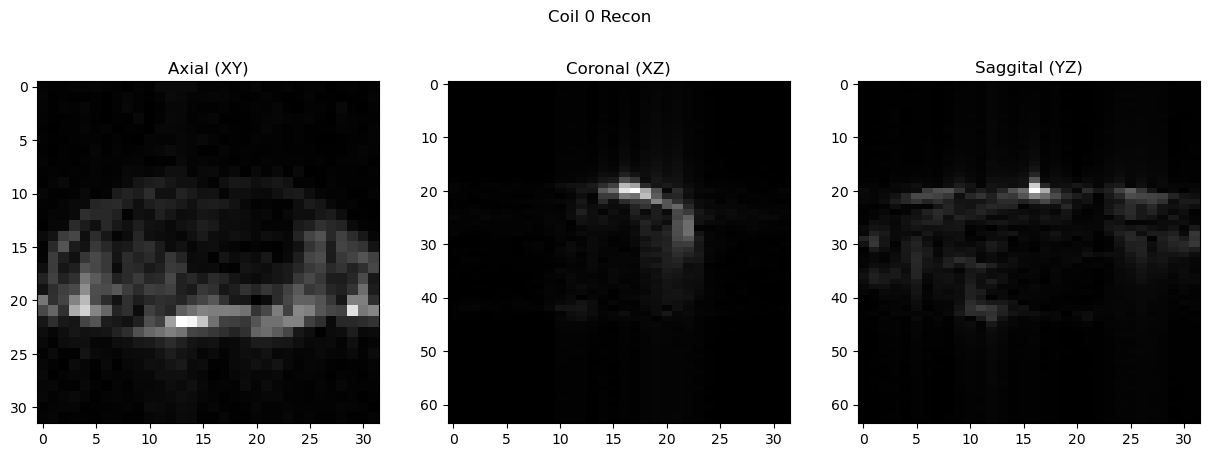

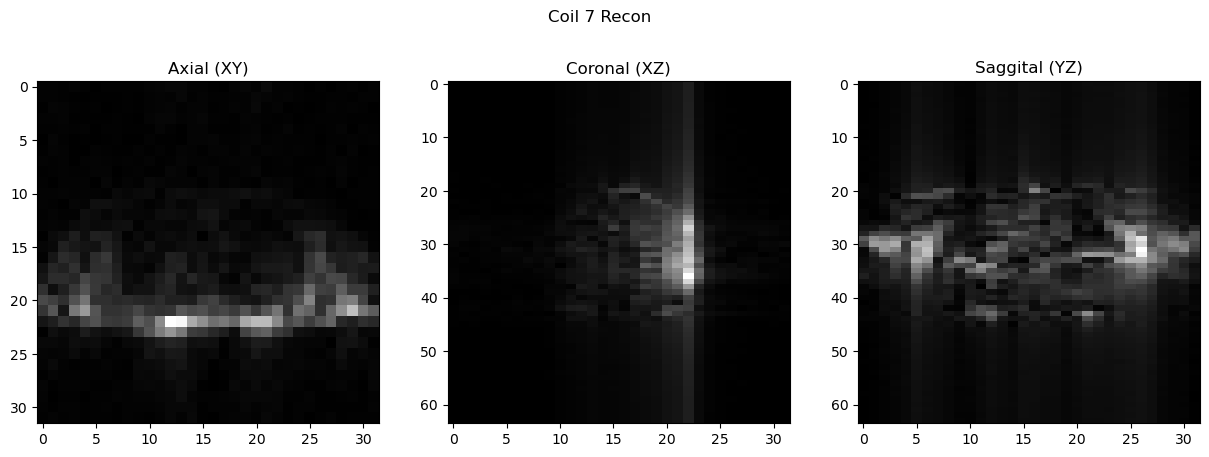

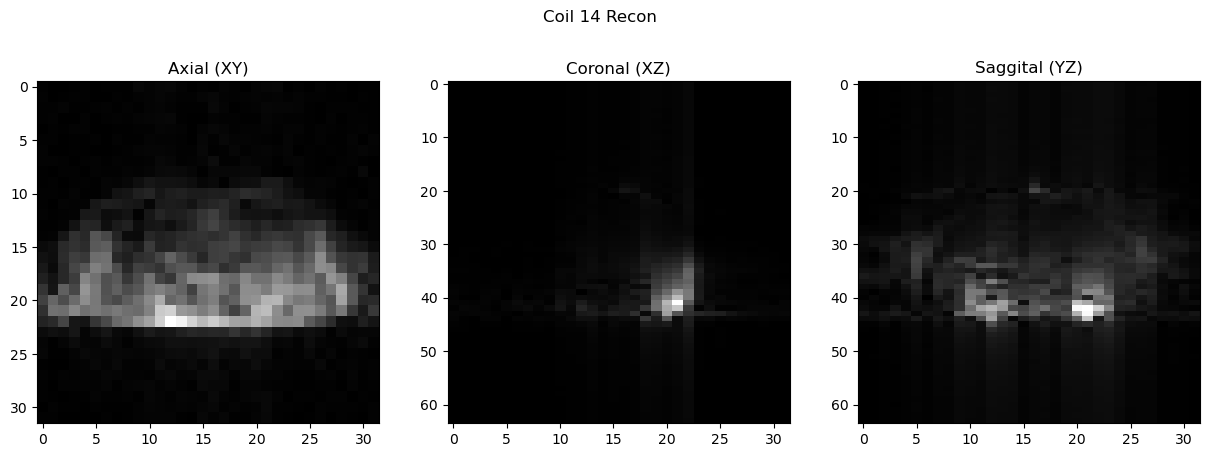

In [3]:
def display_coil_data(img, coil_idx, z_idx=None, y_idx=None, x_idx=None):
    _, Nz, Ny, Nx = img.shape
    # img =  np.zeros((Nz, Ny, Nx))
    if z_idx is None:
        z_idx = Nz//2
    if y_idx is None:
        y_idx = Ny //2
    if x_idx is None:
        x_idx = Nx//2
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    aspect = Nx / Nz
    axs[0].imshow(img[coil_idx, z_idx, :, :].T, cmap='gray', aspect=1.)
    axs[0].set_title("Axial (XY)")
    axs[1].imshow(np.rot90(img[coil_idx, :, y_idx, :].T, k=1), cmap='gray', aspect=aspect)
    axs[1].set_title("Coronal (XZ)")
    axs[2].imshow(np.rot90(img[coil_idx, :, :, x_idx].T, k=1), cmap='gray', aspect=aspect)
    axs[2].set_title("Saggital (YZ)")

    fig.suptitle(f"Coil {coil_idx} Recon")
    plt.show()

display_coil_data(low_res_coil_recons, coil_idx=0)
display_coil_data(low_res_coil_recons, coil_idx=7)
display_coil_data(low_res_coil_recons, coil_idx=14)

### Display Sum-of-Squares Recon

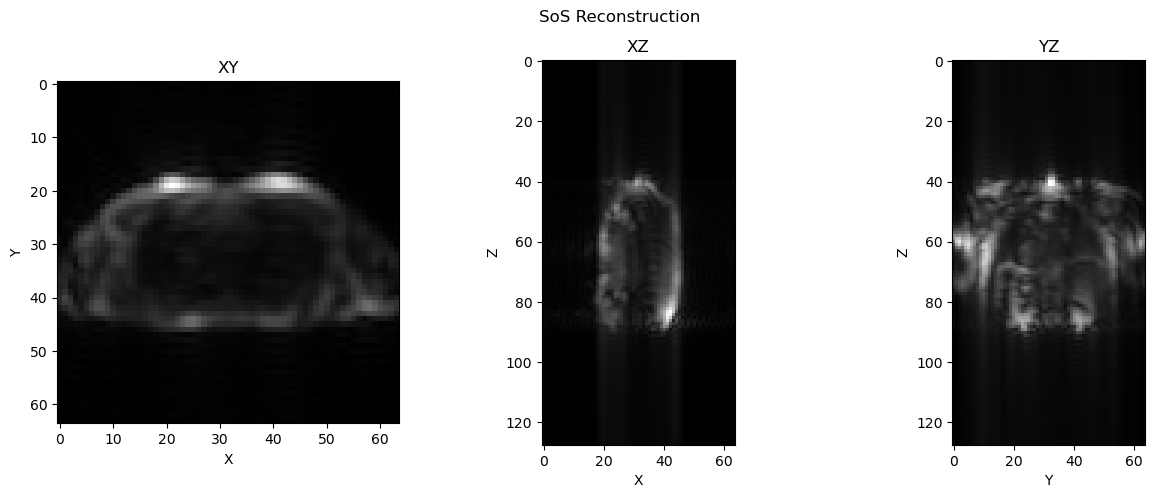

In [4]:
def display_sos_img(sos_img, plot=True, x_idx=None, y_idx=None, z_idx=None):
    Nz, Ny, Nx = sos_img.shape

    if z_idx is None:
        z_idx = Nz //2
    if y_idx is None:
        y_idx = Ny//2
    if x_idx is None:
        x_idx = Nx //2

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    ## Plot all  3 views
    ## Data coordinate system is rotated 90 degrees from standard anatomical conventions
    axs[0].imshow((sos_img[z_idx,:, :]).T, cmap='gray', aspect=1.)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title(f"XY")

    axs[1].imshow(np.rot90(sos_img[:, y_idx, :].T, k=1), cmap='gray', aspect=1.)
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Z")
    axs[1].set_title(f"XZ")

    axs[2].imshow(np.rot90(sos_img[:, :, x_idx].T, k=1), cmap='gray', aspect=1.)
    axs[2].set_xlabel("Y")
    axs[2].set_ylabel("Z")
    axs[2].set_title(f"YZ")
    
    fig.suptitle(f"SoS Reconstruction")

    plt.show()

display_sos_img(low_res_sos)

### Divide coil images by SoS recon

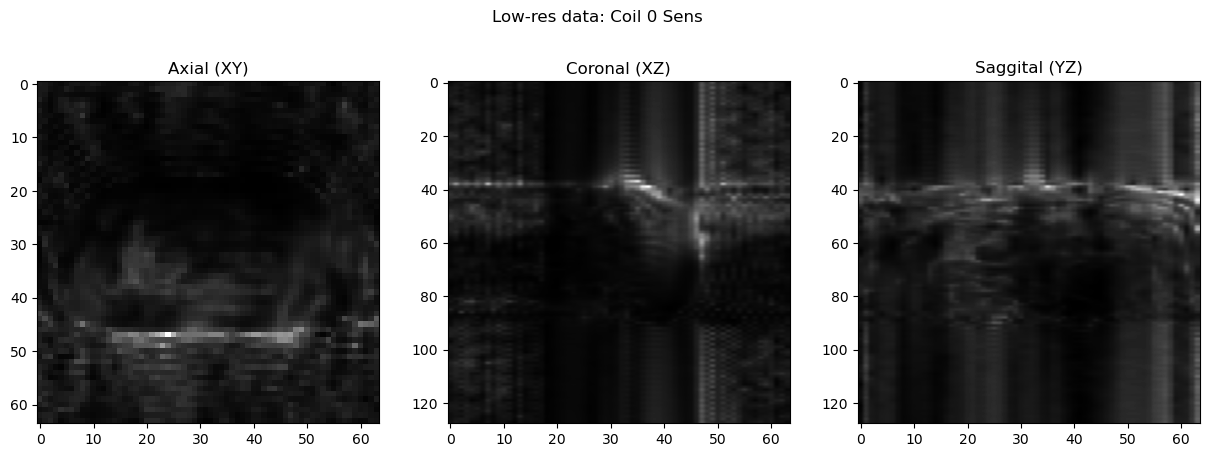

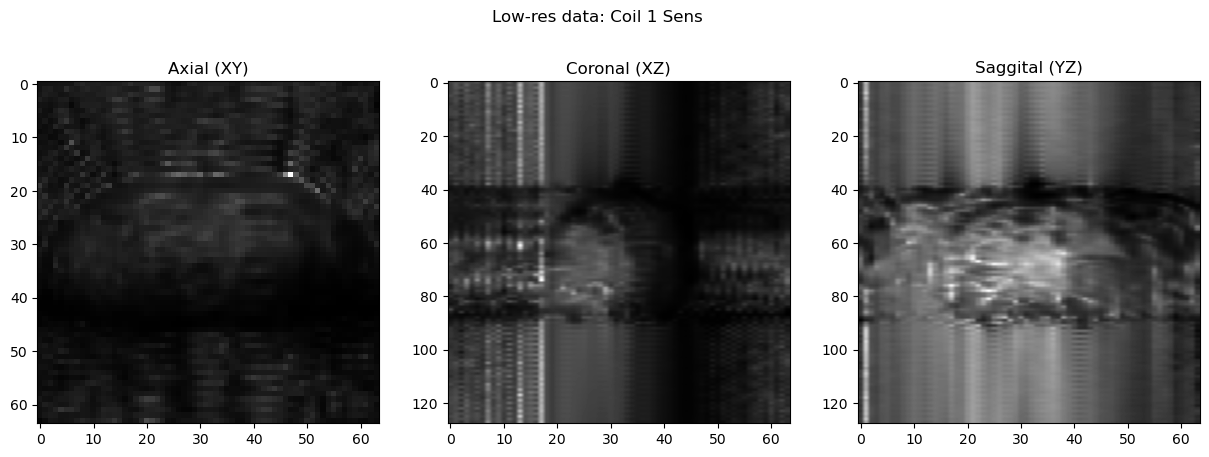

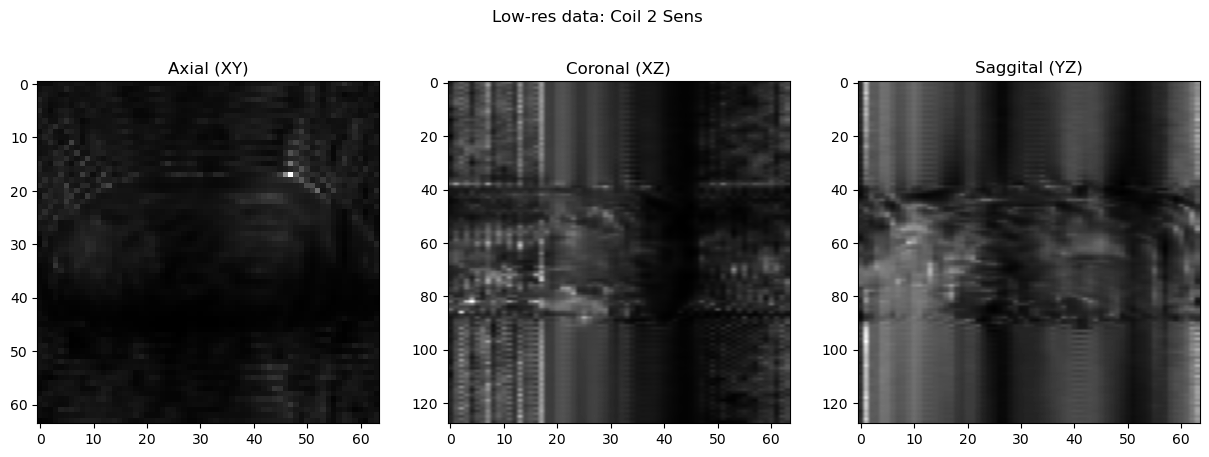

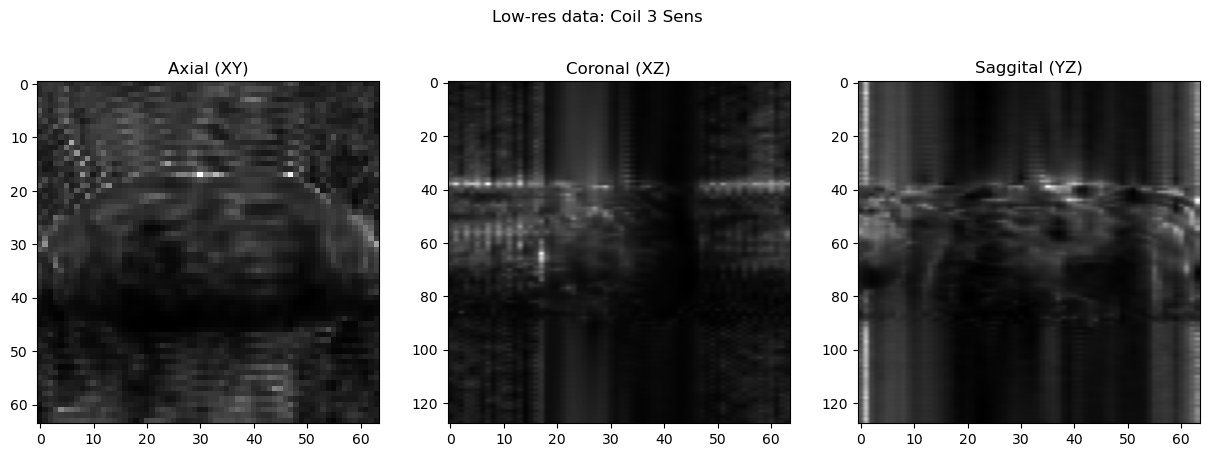

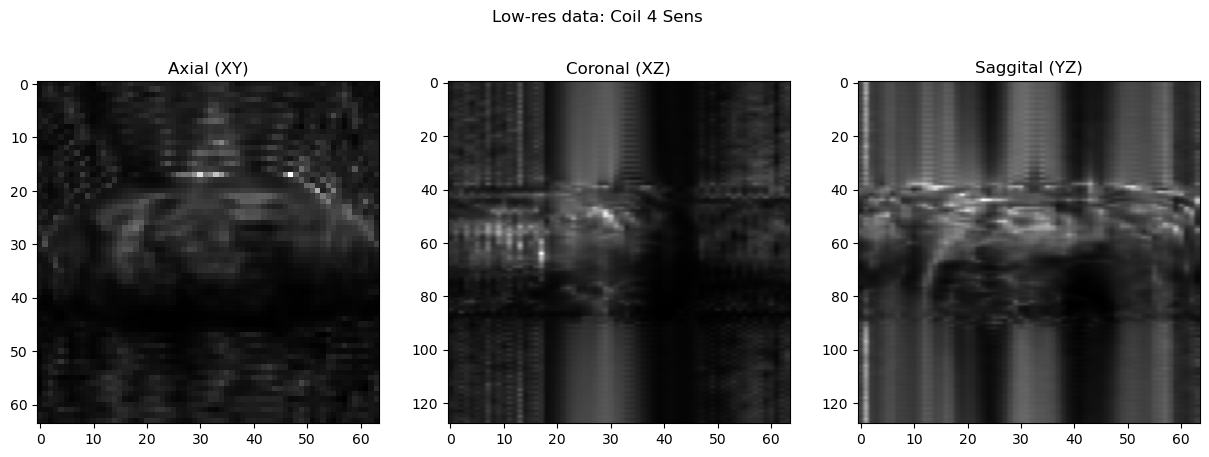

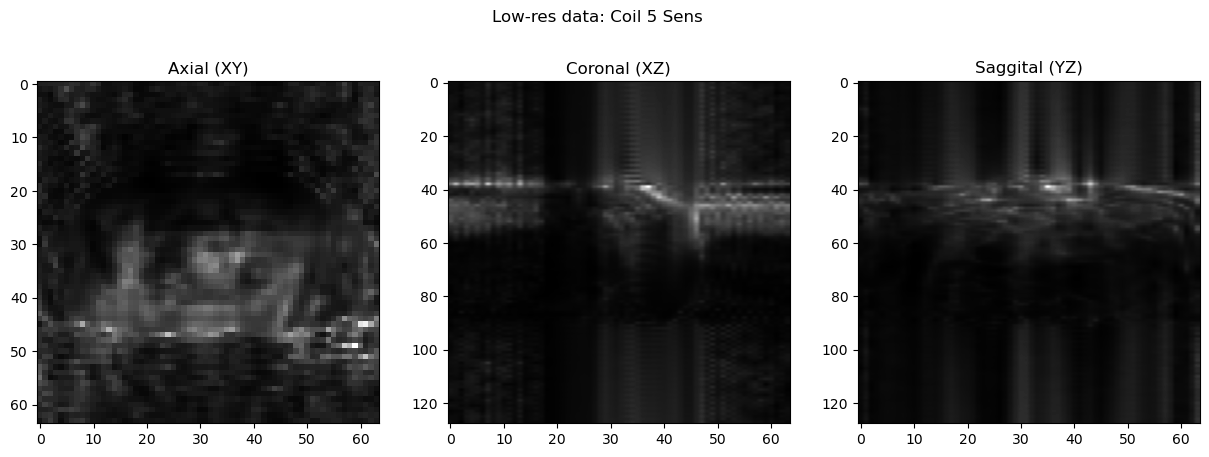

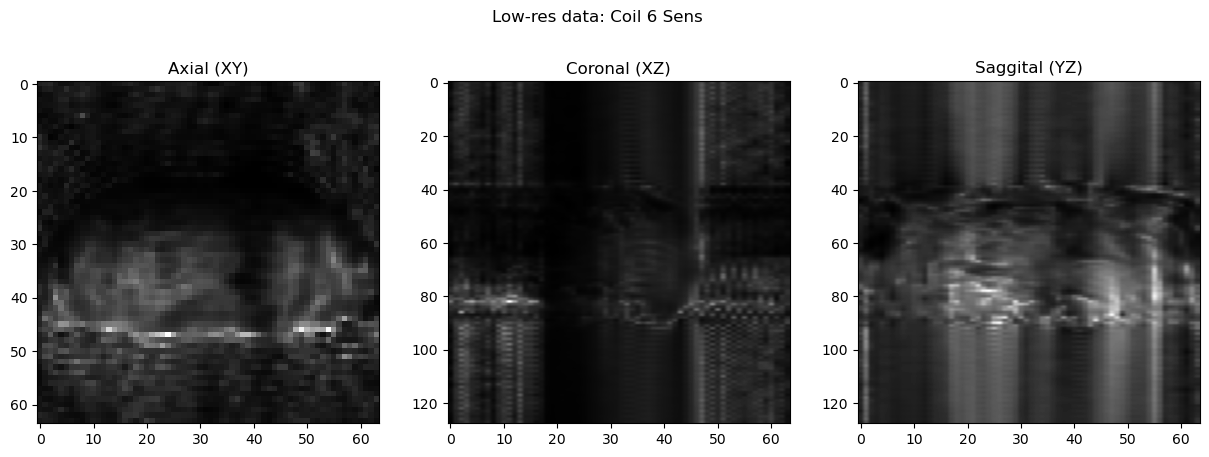

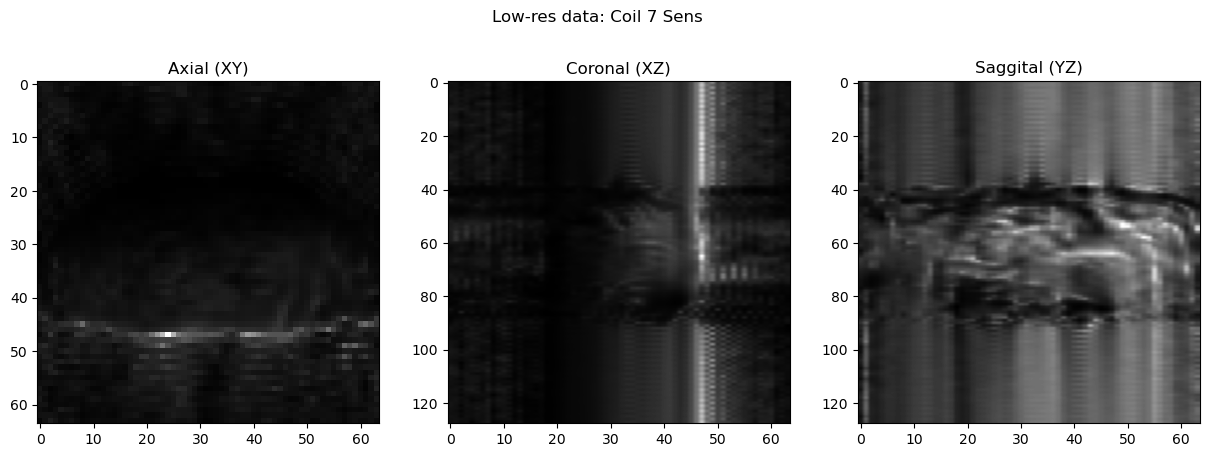

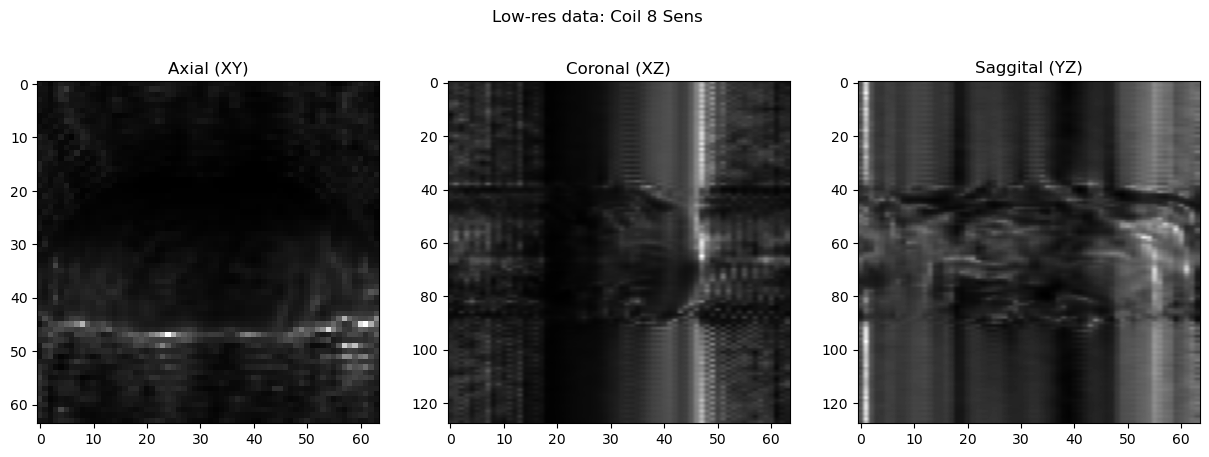

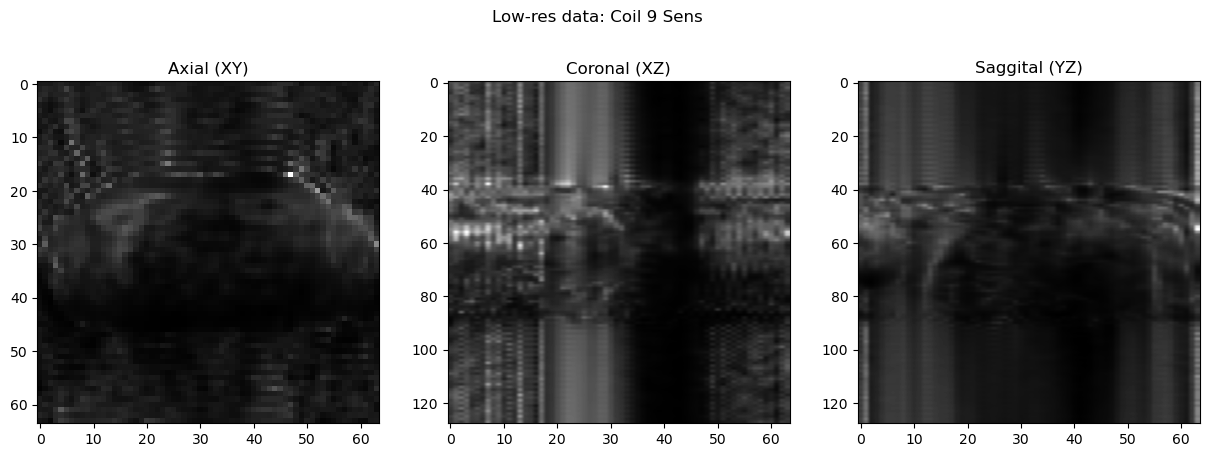

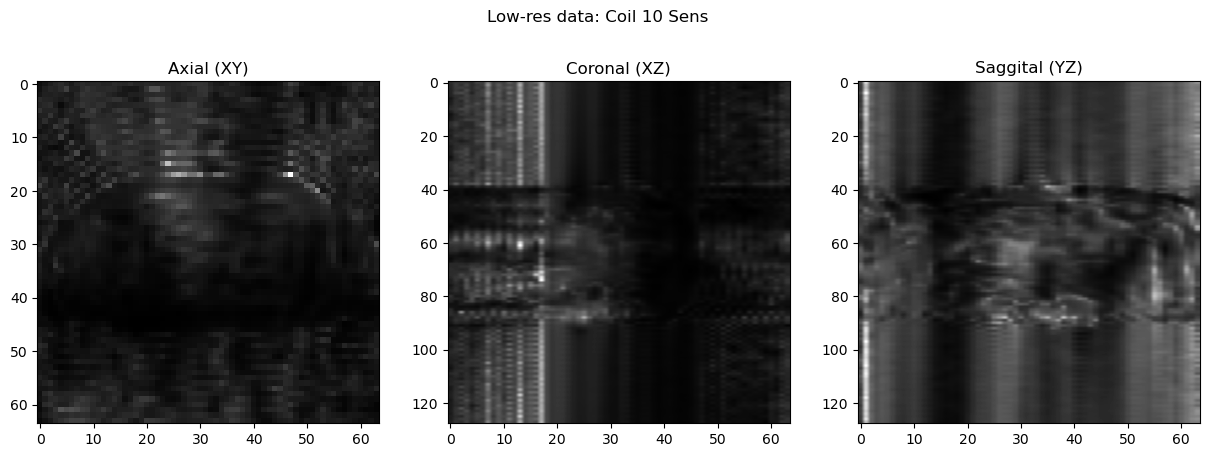

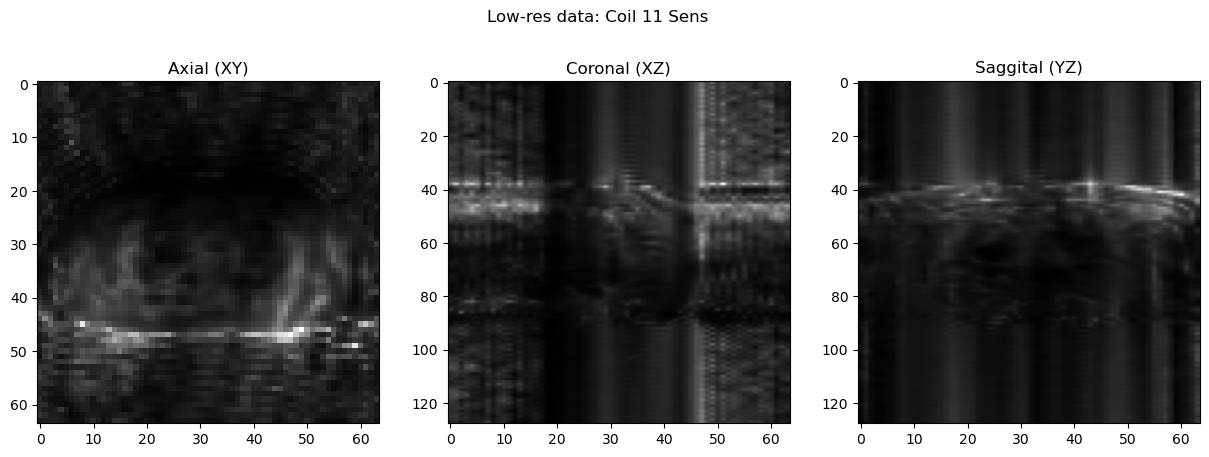

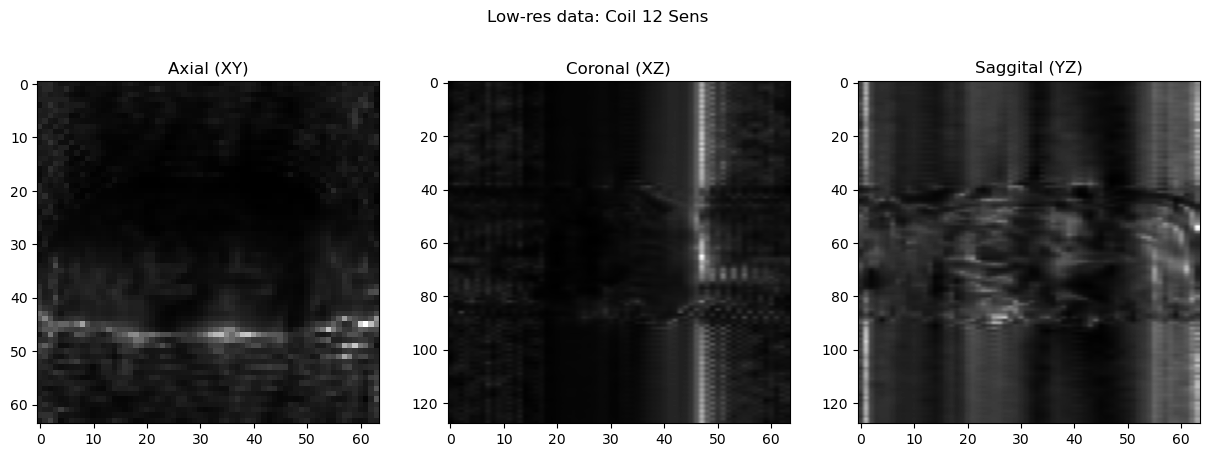

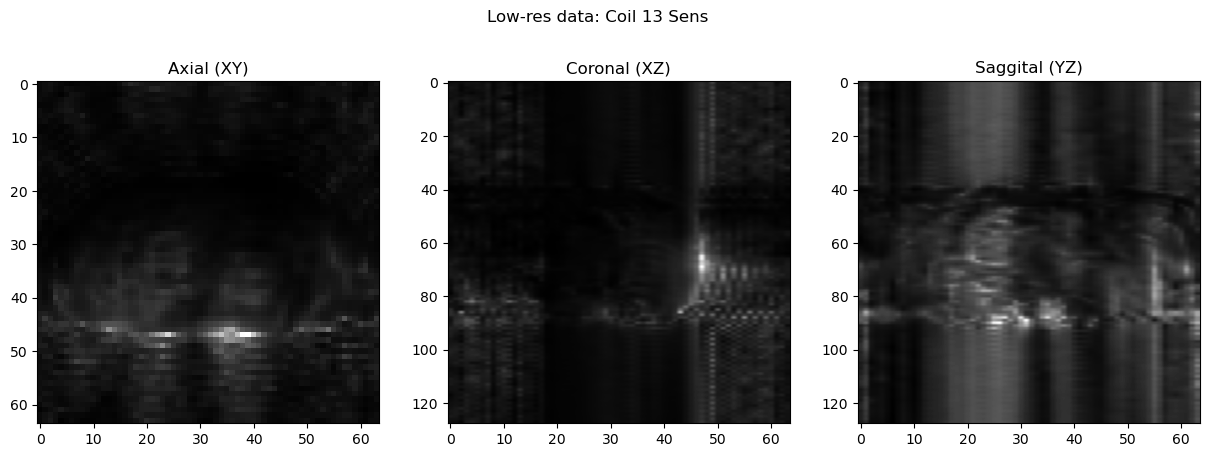

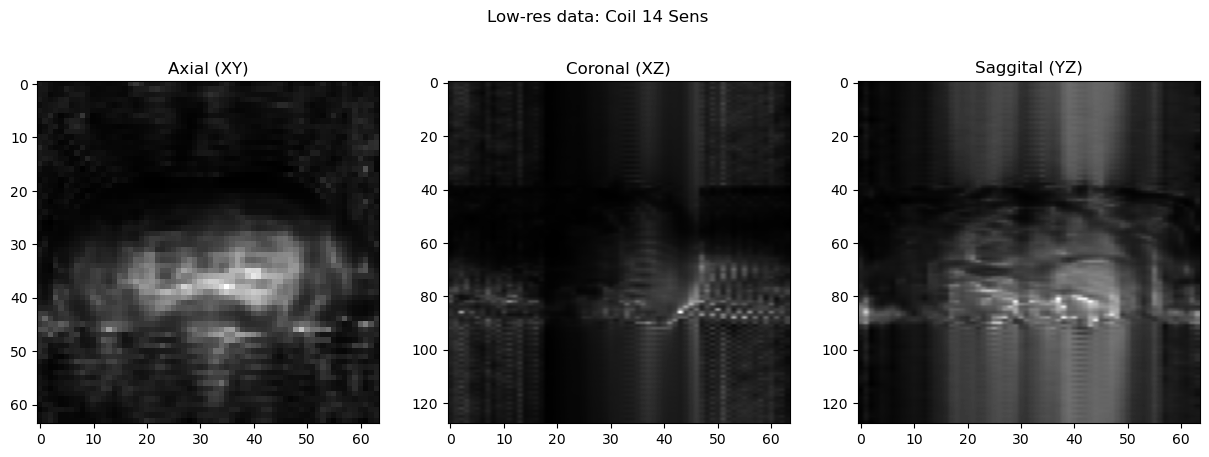

In [5]:
from scipy.ndimage import zoom

def upsample(low_res_coil_recons, target_shape):
    ncoils = low_res_coil_recons.shape[0]

    # Only upsample spatial dims, not coil dim
    zoom_factors = [1] + [t/s for t, s in zip(target_shape[-3:], low_res_coil_recons.shape[-3:])]
    upsampled = zoom(low_res_coil_recons, zoom_factors, order=1)  # order=1: linear interpolation
    return upsampled

def calculate_coil_sens(low_res_coil_recons, sos_img, plot=True, coil_idx=None, z_idx=None, y_idx=None, x_idx=None):
    ## Initialize empty array for coil sens images
    ncoils  = low_res_coil_recons.shape[0]
    Nz, Ny, Nx = sos_img.shape
    
    coil_sens_images = np.zeros((ncoils, Nz, Ny, Nx))

    upsampled_coil_recons = upsample(low_res_coil_recons, sos_img.shape)

    for i in range(ncoils):
        coil_sens_images[i] = upsampled_coil_recons[i] / sos_img
    
    if plot is True:
        ## Set indices if not set
        if z_idx is None:
            z_idx = Nz//2
        if y_idx is None:
            y_idx = Ny //2
        if x_idx is None:
            x_idx = Nx//2

        if coil_idx is not None:
            fig, axs = plt.subplots(1,3, figsize=(15, 5))
            aspect = Nz /Nx

            axs[0].imshow(coil_sens_images[coil_idx, z_idx, :, :].T, cmap='gray', aspect=1.)
            axs[0].set_title("Axial (XY)")
            axs[1].imshow(np.rot90(coil_sens_images[coil_idx, :, y_idx, :].T, k=1), cmap='gray', aspect=aspect)
            axs[1].set_title("Coronal (XZ)")
            axs[2].imshow(np.rot90(coil_sens_images[coil_idx, :, :, x_idx].T, k=1), cmap='gray', aspect=aspect)
            axs[2].set_title("Saggital (YZ)")
            fig.suptitle(f"Low-res data: Coil {coil_idx} Sens ")
            plt.show()
    
        if coil_idx is None:
            for i in range(ncoils):
                fig, axs = plt.subplots(1,3, figsize=(15, 5))
                aspect = Nx/Nz

                axs[0].imshow(coil_sens_images[i, z_idx, :, :].T, cmap='gray', aspect=1.)
                axs[0].set_title("Axial (XY)")
                axs[1].imshow(np.rot90(coil_sens_images[i, :, y_idx, :].T, k=1), cmap='gray', aspect=aspect)
                axs[1].set_title("Coronal (XZ)")
                axs[2].imshow(np.rot90(coil_sens_images[i, :, :, x_idx].T, k=1), cmap='gray', aspect=aspect)
                axs[2].set_title("Saggital (YZ)")
                fig.suptitle(f"Low-res data: Coil {i} Sens ")
                plt.show()


calculate_coil_sens(low_res_coil_recons, low_res_sos)